In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MetaTrader5 as mt5

In [2]:
lista_indices = ['IMAT','IFNC', 'IFIX', 'ICON', 'IBXX',
                 'IMOB', 'IDIV']

In [10]:
def open_ativo_mt5(symbol, periodo = 60):
    mt5.initialize()
    ativo = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_MN1, 0, periodo)
    ativo = pd.DataFrame(ativo)
    ativo['time'] = pd.to_datetime(ativo['time'], unit='s', errors='ignore')
    ativo = ativo.loc[:,['time', 'close']]
    ativo.columns = ['Date', symbol]  
    return ativo

def retornos(df, colunas, periodo=1):
    new_df = pd.DataFrame(columns=colunas)
    for coluna in colunas:
        new_df[coluna] = df[coluna].pct_change(periodo)
    return new_df

def retorno_final(df):
    new_df = pd.DataFrame(columns=df.columns)
    for coluna in df.columns:
        new_df[coluna] = (df[coluna]+1).cumprod() 
    new_df.index = df.index
    return new_df

### Estratégia 01 - Investindo no pior retorno do último período
- A ideia é investir no setor mais atrasado, buscando uma reversão
- Iremos receber um dataframe com os retornos acumulado no período e mensais
- A ideia é entrar naquele que até então teve a pior performance e entrar comprado nesse setor

In [7]:
def estrategia_01(df_acumulado, df_retornos):
    new_arr = np.zeros(len(df_acumulado.index))
    for i in range(1,len(df_acumulado.index)):
        if df_acumulado.iloc[i-1, :].isnull().any():
            pass
        else:
            col = list(df_acumulado.iloc[i-1, :])  
            indice = col.index(min(col))
            new_arr[i] = df_retornos.iloc[i, indice]
    return new_arr

### Estratégia 02 - Investindo no melhor retorno do último período
- A ideia é investir no setor de melhor performance, buscando seguir a tendência.
- Iremos receber um dataframe com os retornos acumulado no período e mensais
- A ideia é entrar naquele que até então teve a melhor performance e entrar comprado nesse setor

In [13]:
def estrategia_02(df_acumulado, df_retornos):
    new_arr = np.zeros(len(df_acumulado.index))
    for i in range(1,len(df_acumulado.index)):
        if df_acumulado.iloc[i-1, :].isnull().any():
            pass
        else:
            col = list(df_acumulado.iloc[i-1, :])  
            indice = col.index(max(col))
            new_arr[i] = df_retornos.iloc[i, indice]
    return new_arr

### Estratégia 03 -
- A ideia é investir no setor de melhor performance entre meses seguintes
- Aqui buscando seguir o momento
- Iremos receber um dataframe com os retornos mensais
- A partir do terceiro retorno iremos comparar os dois últimos retornos, mês imediantamente anterior menos o de dois meses atrás
- Teremos duas formas de entrar:
    - Se melhor == True: Veremos o maior valor obtido na subtração anterior e entraremos comprado nesse setor
    - Se melhor == False: Todos aqueles em que a subtração foi positiva, entrando de forma ponderada em cada setor

In [27]:
def estrategia03(df_retornos, melhor = False):
    new_arr = np.zeros(len(df_retornos.index))
    for i in range(2,len(df_retornos.index)):
        rent = []
        incl_retorno = []
        peso = 0
        for j in range(len(df_retornos.columns)):
            if (df_retornos.iloc[i-1, j] > df_retornos.iloc[i-2, j]): 
                incl_retorno.append(df_retornos.iloc[i-1, j]-df_retornos.iloc[i-2, j])
                peso +=1
                rent.append(df_retornos.iloc[i, j])
        if melhor == True:
            try:
                k = incl_retorno.index(max(incl_retorno))
                new_arr[i] = rent[k]
            except:
                new_arr[i] = 0
        else:
            soma = 0
            for retorno in rent:
                soma = soma + retorno/peso
            new_arr[i] = soma
    return new_arr

### Estratégia 04 - Operando venda e compra na estratégia 03
- A ideia é investir no setor de melhor performance, entre meses seguintes, na compra e no de pior na venda 
- Aqui buscando seguir o momento, hedgeando com vendas
- Iremos receber um dataframe com os retornos mensais
- A partir do terceiro retorno iremos comparar os dois últimos retornos, mês imediantamente anterior menos o de dois meses atrás
- Valores positivos irão pra compra e negativos para venda

In [28]:
def estrategia04(df_retornos):
    new_arr_compra = np.zeros(len(df_retornos.index))
    new_arr_venda = np.zeros(len(df_retornos.index))
    
    for i in range(3,len(df_retornos.index)):
        rent_compra = []
        rent_venda = []
        incl_retorno_compra = []
        incl_retorno_venda = []
        
 
        for j in range(len(df_retornos.columns)):
            if (df_retornos.iloc[i-1, j] > df_retornos.iloc[i-2, j]): 
                incl_retorno_compra.append(df_retornos.iloc[i-1, j]-df_retornos.iloc[i-2, j])
                
                rent_compra.append(df_retornos.iloc[i, j])
            else:
                incl_retorno_venda.append(df_retornos.iloc[i-1, j]-df_retornos.iloc[i-2, j])
                
                rent_venda.append(df_retornos.iloc[i, j])
                

        try:
            k = incl_retorno_compra.index(max(incl_retorno_compra))
            new_arr_compra[i] = rent_compra[k]
        except:
            new_arr_compra[i] = 0
            
        try:
            k = incl_retorno_venda.index(min(incl_retorno_venda))
            new_arr_venda[i] = -rent_venda[k]            
        except:
            new_arr_venda[i] = 0
       
    return new_arr_compra, new_arr_venda

### Inicializando os Dados

In [8]:
dados = pd.DataFrame()
meses = 200
n_retornos = 6

for indice in lista_indices:
    df = open_ativo_mt5(indice, periodo=meses)
    if (dados.empty):
        dados = df
    else:
        dados = pd.merge(dados, df, on='Date', how='inner')

In [9]:
colunas = dados.columns[1:]
df_retornos = retornos(dados, colunas)
df_acumulado = retornos(dados, colunas, periodo=n_retornos)
colors = ['red','blue','orange','gray',
          'lawngreen','darkmagenta','cyan','firebrick']

### Estratégia 01 - Aplicação

In [11]:
dados['Estrategia'] = estrategia_01(df_acumulado, df_retornos)

df_final = df_retornos.copy(True)
df_final['Estrategia'] = dados['Estrategia']
df_final.index = dados['Date'].values

estrategia = retorno_final(df_final)

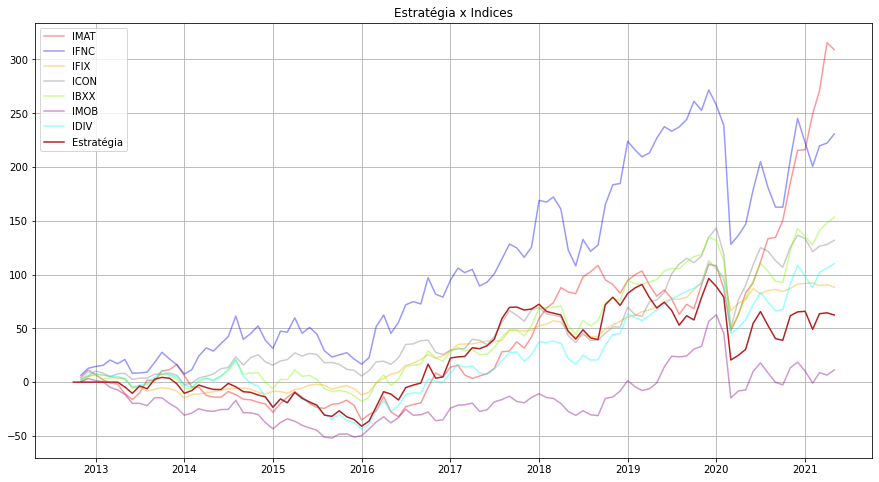

In [12]:
plt.figure(figsize=(15, 8))
plt.title('Estratégia x Indices')
for i in range(8):
    if i < 7:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                 alpha = 0.4, label=lista_indices[i])
    else:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                     alpha = 1, label='Estratégia')
plt.legend()
plt.grid()
plt.show()

### Estratégia 02 - Aplicação

In [14]:
dados['Estrategia'] = estrategia_02(df_acumulado, df_retornos)

df_final = df_retornos.copy(True)
df_final['Estrategia'] = dados.loc[:,'Estrategia'] 
df_final.index = dados['Date'].values

estrategia = retorno_final(df_final)

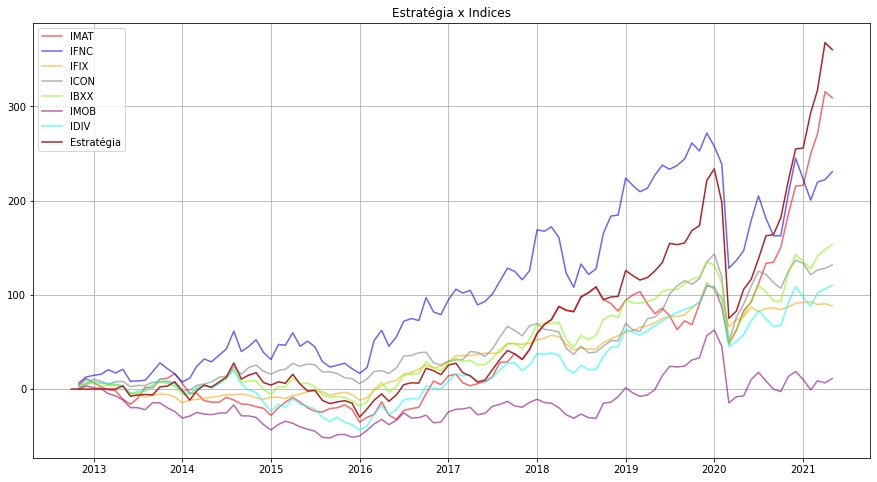

In [15]:
colors = ['red','blue','orange','gray',
          'lawngreen','darkmagenta','cyan','firebrick']

plt.figure(figsize=(15, 8))
plt.title('Estratégia x Indices')
for i in range(8):
    if i < 7:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                 alpha = 0.4, label=lista_indices[i])
    else:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                     alpha = 1, label='Estratégia')
plt.legend()
plt.grid()
plt.show()

### Estratégia 03.1 - Aplicação - melhor = True

In [19]:
dados['Estrategia'] = estrategia03(df_retornos, melhor=True)

df_final = df_retornos.copy(True)
df_final['Estrategia'] = dados.loc[:,'Estrategia']
df_final.index = dados['Date'].values[:]

estrategia = retorno_final(df_final)

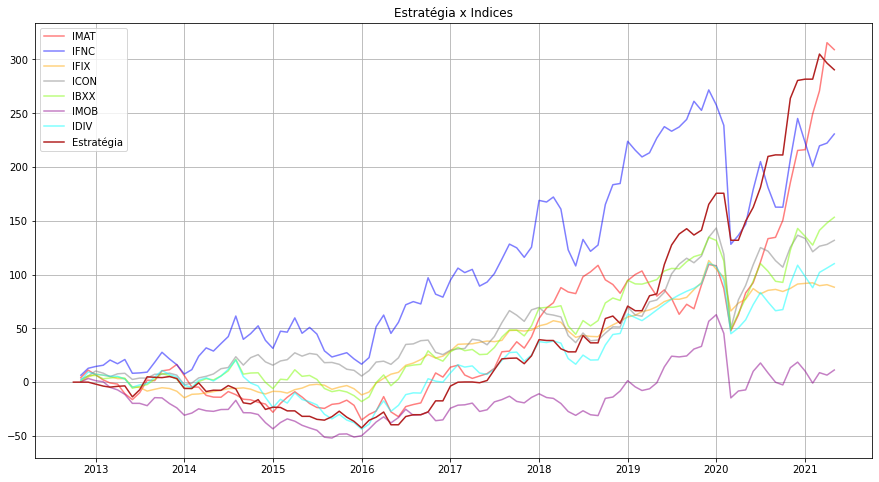

In [20]:
colors = ['red','blue','orange','gray',
          'lawngreen','darkmagenta','cyan','firebrick']

plt.figure(figsize=(15, 8))
plt.title('Estratégia x Indices')
for i in range(8):
    if i < 7:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                 alpha = 0.4, label=lista_indices[i])
    else:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                     alpha = 1, label='Estratégia')
plt.legend()
plt.grid()
plt.show()

### Estratégia 03.2 - Aplicação - melhor = False

In [22]:
dados['Estrategia'] = estrategia03(df_retornos, melhor=False)

df_final = df_retornos.copy(True)
df_final['Estrategia'] = dados.loc[:,'Estrategia']
df_final.index = dados['Date'].values[:]

estrategia = retorno_final(df_final)

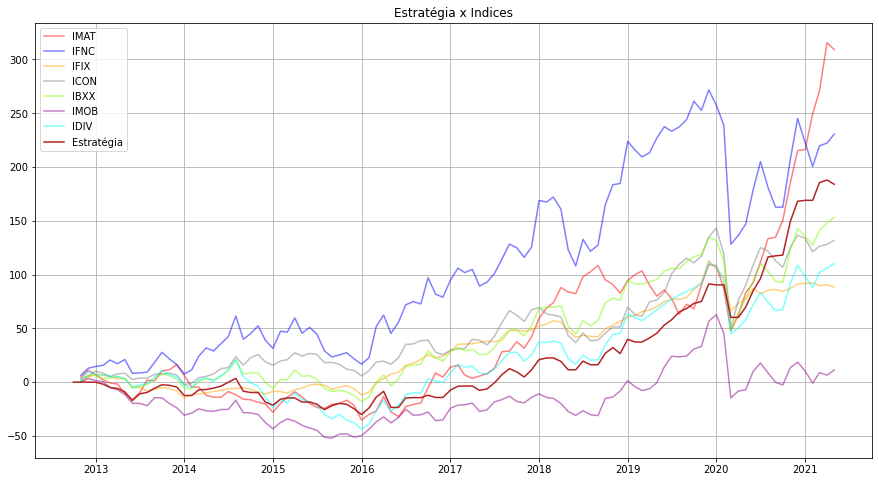

In [23]:
colors = ['red','blue','orange','gray',
          'lawngreen','darkmagenta','cyan','firebrick']

plt.figure(figsize=(15, 8))
plt.title('Estratégia x Indices')
for i in range(8):
    if i < 7:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                 alpha = 0.4, label=lista_indices[i])
    else:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                     alpha = 1, label='Estratégia')
plt.legend()
plt.grid()
plt.show()

### Estratégia 04 - Aplicação 

In [29]:
dados['Estrategia_Compra'], dados['Estrategia_Venda'] = estrategia04(df_retornos)

df_final = df_retornos.copy(True)
df_final['Estrategia_Compra'] = dados.loc[:,'Estrategia_Compra']
df_final['Estrategia_Venda'] = dados.loc[:,'Estrategia_Venda']
df_final['Combinada'] = df_final['Estrategia_Compra'] + df_final['Estrategia_Venda']
df_final.index = dados['Date'].values[:]

estrategia = retorno_final(df_final)

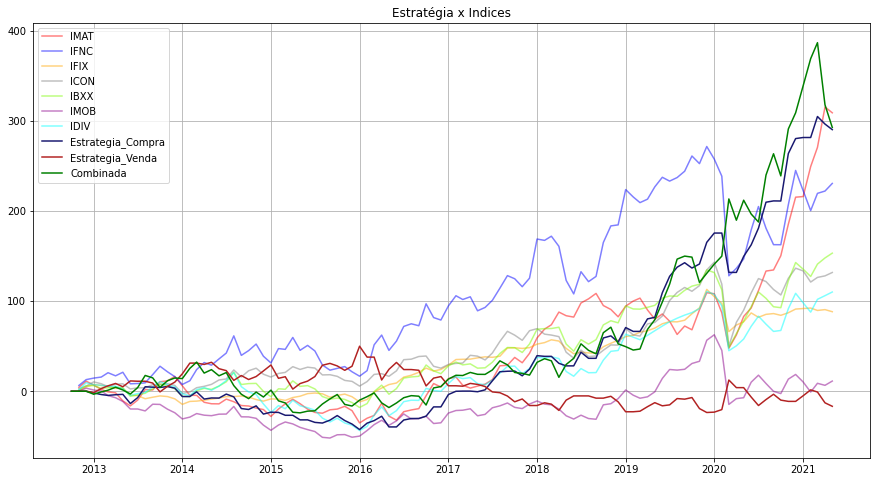

In [33]:
colors = ['red','blue','orange','gray',
          'lawngreen','darkmagenta','cyan','midnightblue','firebrick', 'green']

plt.figure(figsize=(15, 8))
plt.title('Estratégia x Indices')
for i in range(10):
    if i < 7:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                 alpha = 0.4, label=estrategia.columns[i])
    else:
        plt.plot(estrategia.index, (estrategia.iloc[:,i]-1)*100 , color=colors[i], 
                     alpha = 1, label=estrategia.columns[i])
plt.legend()
plt.grid()
plt.show()